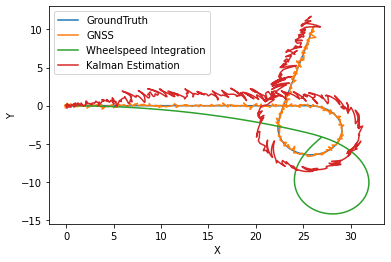

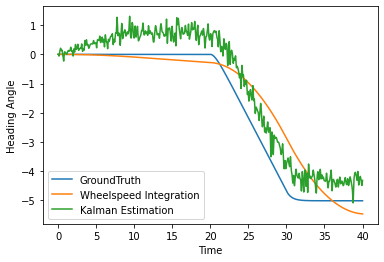

<Figure size 432x288 with 0 Axes>

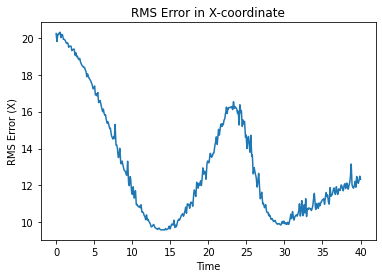

<Figure size 432x288 with 0 Axes>

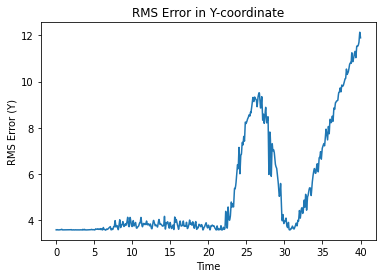

<Figure size 432x288 with 0 Axes>

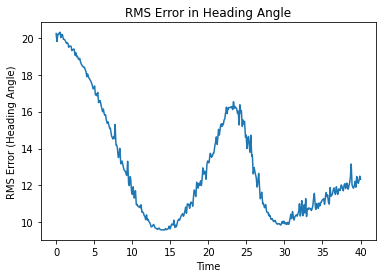

<Figure size 432x288 with 0 Axes>

In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# Helper function to calculate error between estimated values and ground truth
def calculate_error(X, gtruth):
    N = X.shape[0]
    error = np.zeros((N, N))

    for col in range(N):
        for row in range(N):
            error[row, col] = X[col] - gtruth[row]
    return error

# Helper function to calculate root mean square (RMS) error
def calculate_rms(X):
    N = X.shape[0]
    rms = np.zeros((1, N))

    for i in range(N):
        rms[:, i] = np.sqrt(np.mean(np.square(X[:, i])))
    return rms

# Read input data from CSV files
gnss = pd.read_csv('gnss-1.csv')
groundtruth = pd.read_csv('groundtruth-1.csv')
wheelspeeds = pd.read_csv('wheelspeeds-1.csv')

# Constants and parameters
R = 0.27  # Wheel radius

vR = wheelspeeds['vr'].values
vL = wheelspeeds['vl'].values

# Initialize variables
phi = np.zeros_like(vR)
Vx = np.zeros_like(vR)
Vy = np.zeros_like(vR)
x = np.zeros_like(vR)
y = np.zeros_like(vR)
dt = 0.005

# Calculate heading angle at each time instant
for k in range(1, len(vR)):
    # Calculate the incremental change in heading angle
    phi_dot = (vR[k] - vL[k]) / (2 * R)

    # Accumulate the incremental changes to obtain the cumulative heading angle
    phi[k] = phi[k-1] + phi_dot * dt
    Vx[k] = ((vR[k] + vL[k])/2) * np.cos(phi[k])
    Vy[k] = ((vR[k] + vL[k])/2) * np.sin(phi[k])

    # Accumulate the incremental changes to obtain the cumulative position coordinates
    x[k] = x[k-1] + Vx[k] * dt
    y[k] = y[k-1] + Vy[k] * dt

# Estimation using Kalman
# Constants and parameters
delta_t = 0.005  # Time interval between measurements
R = 0.27  # Wheel radius

# Measurement noise covariance matrix
R_t = np.eye(4)  # Assuming uncorrelated measurement noise

# Process noise covariance matrix
Q_t = np.diag([1, 1, 1, 1])  # Tuned process noise covariance matrix

# Interpolate GNSS measurements
t_gnss = np.linspace(0, 40, len(gnss['x']))
t_interp = np.linspace(0, 40, len(vR))
gnss_x = interp1d(t_gnss, gnss['x'], kind='linear')(t_interp)
gnss_y = interp1d(t_gnss, gnss['y'], kind='linear')(t_interp)

# Initialize variables
n = len(vR)  # Number of time instants
x_t = np.array([0, 0, 0, 0])  # Initial state estimate
P_k_prev = np.eye(4)  # Initial covariance matrix
X = np.zeros((4, n))  # State estimates
P = np.zeros((4, 4, n))  # Covariance matrices
f_t = np.zeros(4)

# Loop over the time instants
for k in range(1, n):
    # Predict step: Propagate the state estimate
    f_t = np.array([(vL[k] + vR[k])/2, x_t[1] + ((vL[k] + vR[k])/2*R)*dt, x_t[2] + ((vL[k] + vR[k])/2)*np.cos(x_t[1]), x_t[3] + ((vL[k] + vR[k])/2)*np.sin(x_t[1])])

    F_k = np.array([[1/2, 0, 0, 0],
                    [0, 1, 0, 0],
                    [np.cos(x_t[1]), -((vL[k] + vR[k])/2)*np.sin(x_t[1]), 1, 0],
                    [np.sin(x_t[1]), ((vL[k] + vR[k])/2)*np.cos(x_t[1]), 0, 1]])

    # Measurement function and its Jacobian
    h_k = x_t
    H_k = np.array([[0, 0, 0, 0],
                    [0, 0, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]])

    # Kalman filter steps
    # 1. 1. Predict: Propagate the state estimate and covariance matrix
    x_k_hat = f_t
    P_k_hat = np.matmul(np.matmul(F_k, P_k_prev), F_k.T) + Q_t

    # Update: Incorporate the measurement
    G_k = np.matmul(np.matmul(P_k_hat, H_k.T), np.linalg.inv(np.matmul(np.matmul(H_k, P_k_hat), H_k.T) + R_t + 1e-6))  # Add a small value to avoid division by zero
    z_k = np.array([0, 0, gnss_x[k], gnss_y[k]])  # gnss measurements at time t
    x_t = x_k_hat + np.matmul(G_k, (z_k - h_k))

    # initialize the P(k-1) in this step to use in the next iteration
    P_k_prev = np.matmul((np.eye(4) - np.matmul(G_k, H_k)), P_k_hat)

    # Store the updated state estimate and covariance matrix
    X[:, k] = x_t
    P[:, :, k] = P_k_prev

# Calculate errors between estimated values and ground truth
gtruth = groundtruth.to_numpy().T
error_x = calculate_error(X[2, :], gtruth[1, :])
rms_x = calculate_rms(error_x)

error_y = calculate_error(X[3, :], gtruth[2, :])
rms_y = calculate_rms(error_y)

error_phi = calculate_error(X[1, :], gtruth[3, :])
rms_phi = calculate_rms(error_phi)

# Plotting
plt.figure(4)
plt.plot(groundtruth['x'], groundtruth['y'], label='GroundTruth')
plt.plot(gnss['x'], gnss['y'], label='GNSS')
plt.plot(x, y, label='Wheelspeed Integration')
plt.plot(X[2, :], X[3, :], label='Kalman Estimation')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.savefig('plot_1.png')

plt.figure(5)
plt.plot(np.arange(0, 40.005, 0.005), groundtruth['phi'], label='GroundTruth')
plt.plot(np.arange(0, 40.005, 0.005), phi, label='Wheelspeed Integration')
plt.plot(np.arange(0, 40.005, 0.005), X[1, :], label='Kalman Estimation')
plt.xlabel('Time')
plt.ylabel('Heading Angle')
plt.legend()
plt.show()
plt.savefig('plot_2.png')

# Plot RMS errors
t = np.arange(0, 40.005, 0.005)
N = rms_x.size
plt.figure(6)
plt.plot(t[0:N], rms_x.T)
plt.xlabel('Time')
plt.ylabel('RMS Error (X)')
plt.title('RMS Error in X-coordinate')
plt.show()
plt.savefig('plot_3.png')

N = rms_y.size
plt.figure(6)
plt.plot(t[0:N], rms_y.T)
plt.xlabel('Time')
plt.ylabel('RMS Error (Y)')
plt.title('RMS Error in Y-coordinate')
plt.show()
plt.savefig('plot_4.png')

N = rms_phi.size
plt.figure(6)
plt.plot(t[0:N], rms_x.T)
plt.xlabel('Time')
plt.ylabel('RMS Error (Heading Angle)')
plt.title('RMS Error in Heading Angle')
plt.show()
plt.savefig('plot_5.png')

